In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
from collections import defaultdict
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os 
import random
import cv2
from collections import Counter
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import load_img,img_to_array,to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet152V2, EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras import Input
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, AveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
TRAIN_IMAGE_DIR = '/kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/train/images'
TRAIN_LABEL_DIR = '/kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/train/labels'
VALID_IMAGE_DIR = '/kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/valid/images'
VALID_LABEL_DIR = '/kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/valid/labels'
TEST_IMAGE_DIR = '/kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/test/images'
TEST_LABEL_DIR = '/kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/test/labels'

TARGET_SIZE = [224, 224]

def load_images_and_labels(image_dir, label_dir):
    images = []
    class_labels = []
    polygons_list = []

    for img_name in os.listdir(image_dir):
        if img_name.endswith(".jpg") or img_name.endswith(".png"):
            img_path = os.path.join(image_dir, img_name)
            image = cv2.imread(img_path)
            image = cv2.resize(image, TARGET_SIZE)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Normalize
            image = image.astype(np.float32) / 255.0

            label_path = os.path.join(label_dir, img_name.replace(".jpg", ".txt").replace(".png", ".txt"))
            polygons = []
            classes = []

            if os.path.exists(label_path):
                with open(label_path, "r") as f:
                    lines = f.read().strip().split("\n")
                for line in lines:
                    components = line.strip().split()
                    if len(components) > 1:
                        class_id = int(components[0])
                        coords = list(map(float, components[1:]))
                        # Only keep polygons with even number of coords
                        if len(coords) % 2 == 0:
                            classes.append(class_id)
                            polygons.append(coords)

            # Decide image-level class label
            if classes:
                image_level_label = classes[0]   # or use most frequent: max(set(classes), key=classes.count)
            else:
                image_level_label = 'no_fracture'  # your 'no_fracture' label

            images.append(image)
            class_labels.append(image_level_label)
            polygons_list.append(polygons)

    return np.array(images), np.array(class_labels), polygons_list


# Load images, class labels, and polygons
train_images, train_class_labels, train_polygons = load_images_and_labels(TRAIN_IMAGE_DIR, TRAIN_LABEL_DIR)
valid_images, valid_class_labels, valid_polygons = load_images_and_labels(VALID_IMAGE_DIR, VALID_LABEL_DIR)
test_images, test_class_labels, test_polygons = load_images_and_labels(TEST_IMAGE_DIR, TEST_LABEL_DIR)

print(f"Loaded {len(train_images)} images, {len(train_class_labels)} class labels, and {len(train_polygons)} sets of polygons.")
print(f"Loaded {len(valid_images)} images, {len(valid_class_labels)} class labels, and {len(valid_polygons)} sets of polygons.")
print(f"Loaded {len(test_images)} images, {len(test_class_labels)} class labels, and {len(test_polygons)} sets of polygons.")

Loaded 3631 images, 3631 class labels, and 3631 sets of polygons.
Loaded 348 images, 348 class labels, and 348 sets of polygons.
Loaded 169 images, 169 class labels, and 169 sets of polygons.


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


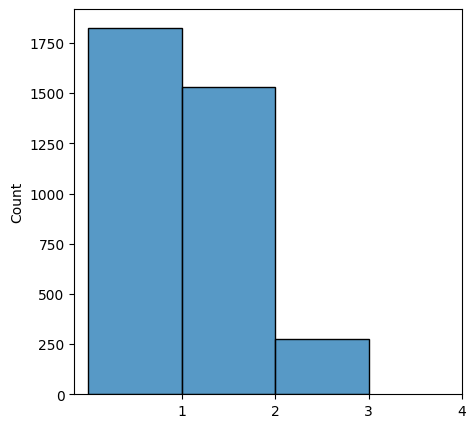

In [3]:
len_train_polygons=[]
for k in range(len(train_polygons)):
    a = len(train_polygons[k])
    len_train_polygons.append(a)
plt.subplots(figsize=(5,5))
sns.histplot(len_train_polygons,binwidth=1)
plt.xticks(np.arange(1, 5, 1))
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


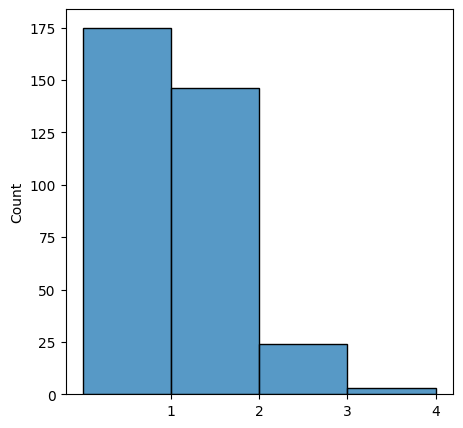

In [4]:
len_valid_polygons=[]
for k in range(len(valid_polygons)):
    a = len(valid_polygons[k])
    len_valid_polygons.append(a)
plt.subplots(figsize=(5,5))
sns.histplot(len_valid_polygons,binwidth=1)
plt.xticks(np.arange(1, 5, 1))
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


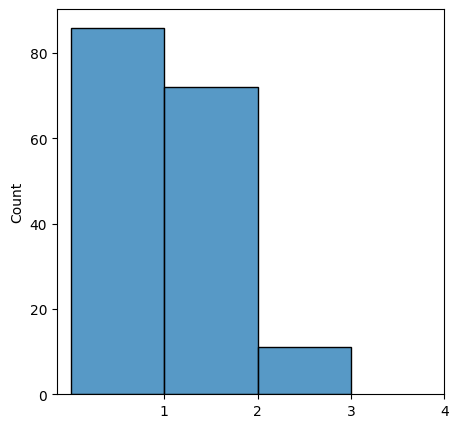

In [5]:
len_test_polygons=[]
for k in range(len(test_polygons)):
    a = len(test_polygons[k])
    len_test_polygons.append(a)
plt.subplots(figsize=(5,5))
sns.histplot(len_test_polygons,binwidth=1)
plt.xticks(np.arange(1, 5, 1))
plt.show()

In [6]:
# TARGET_SIZE = [225, 225]

# def load_images_and_labels(image_dir, label_dir):
#     images = []
#     class_labels = []
#     polygons = []

#     for img_name in os.listdir(image_dir):
#         if img_name.endswith(".jpg") or img_name.endswith(".png"):
#             img_path = os.path.join(image_dir, img_name)
#             image = cv2.imread(img_path)
#             image = cv2.resize(image, TARGET_SIZE)
#             image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#             label_path = os.path.join(label_dir, img_name.replace(".jpg", ".txt").replace(".png", ".txt"))
#             with open(label_path, "r") as f:
#                 label_content = f.read().strip()

#             if label_content:
#                 components = label_content.split()
#                 class_label = components[0]
#                 polygon_coords = list(map(float, components[1:]))

#                 # 🧐 Check: polygon length must be even
#                 if len(polygon_coords) % 2 != 0:
#                     #print(f"⚠ Skipping {img_name}: odd polygon length ({len(polygon_coords)})")
#                     continue
#             else:
#                 class_label = 'no_fracture'
#                 polygon_coords = []

#             images.append(image)
#             class_labels.append(class_label)
#             polygons.append(polygon_coords)

#     return np.array(images), np.array(class_labels), polygons


In [7]:
# train_images, train_class_labels, train_polygons = load_images_and_labels(TRAIN_IMAGE_DIR, TRAIN_LABEL_DIR)
# valid_images, valid_class_labels, valid_polygons = load_images_and_labels(VALID_IMAGE_DIR, VALID_LABEL_DIR)
# test_images, test_class_labels, test_polygons = load_images_and_labels(TEST_IMAGE_DIR, TEST_LABEL_DIR)

# print(f"Loaded {len(train_images)} images, {len(train_class_labels)} class labels, and {len(train_polygons)} sets of polygons.")
# print(f"Loaded {len(valid_images)} images, {len(valid_class_labels)} class labels, and {len(valid_polygons)} sets of polygons.")
# print(f"Loaded {len(test_images)} images, {len(test_class_labels)} class labels, and {len(test_polygons)} sets of polygons.")

In [8]:
# def visualize_images_with_polygons(images, class_labels, polygons_list, num_samples=20):
#     plt.figure(figsize=(20, 12))
    
#     indices = random.sample(range(len(images)), min(num_samples, len(images)))
#     print(indices)
    
#     for i, idx in enumerate(indices):
#         img = images[idx].copy()
#         label = class_labels[idx]
#         polygons = polygons_list[idx]

#         # Draw all polygons for this image
#         for poly in polygons:
#             if poly and len(poly) >= 4:
#                 pts = np.array(poly).reshape(-1, 2)

#                 # If coords are normalized (max <=1.1), scale to image size
#                 if np.max(pts) <= 1.1:
#                     pts[:, 0] *= img.shape[1]
#                     pts[:, 1] *= img.shape[0]

#                 pts = pts.astype(np.int32).reshape((-1,1,2))
#                 img = cv2.polylines(img, [pts], isClosed=True, color=(255,0,0), thickness=2)

#         plt.figure(figsize=(30,30))
#         plt.subplot(4, 5, i+1)
#         plt.imshow(img)
#         plt.title(f"Label: {label}")
#         plt.axis('off')
        
#     plt.tight_layout()
#     plt.show()

In [9]:
# visualize_images_with_polygons(train_images, train_class_labels, train_polygons, num_samples=1)

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

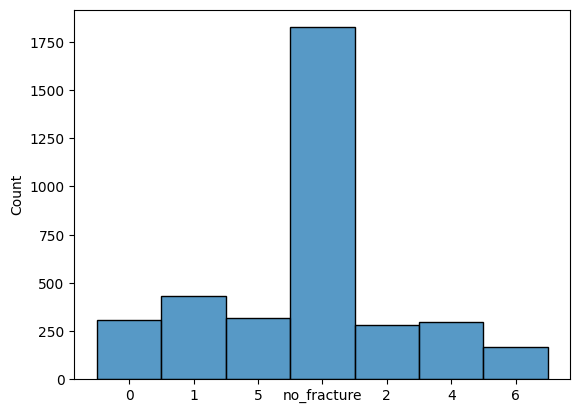

In [10]:
sns.histplot(train_class_labels)

In [11]:
a = []
for i in range(len(train_class_labels)):
    if train_class_labels[i] == '6':
        a.append(train_class_labels[i])

len(a)

168

In [12]:
label_encoder = LabelEncoder()
train_labels_enc = label_encoder.fit_transform(train_class_labels)
valid_labels_enc = label_encoder.transform(valid_class_labels)
test_labels_enc = label_encoder.transform(test_class_labels)

print(label_encoder.classes_)  # to know the actual labels

['0' '1' '2' '4' '5' '6' 'no_fracture']


In [13]:

# Example: train_images = np.array([...]), train_labels = np.array([...])
class_groups = defaultdict(list)

for img, label in zip(train_images, train_labels_enc):  # assuming integer-encoded labels
    class_groups[label].append(img)

# Convert lists to arrays
for k in class_groups:
    class_groups[k] = np.array(class_groups[k])

In [14]:
no_fracture_label = 6 
train_images_list, train_labels_list = [], []

for label, images in class_groups.items():
    if len(images) == 0:
        continue
    if label == no_fracture_label:
        train_images_list.append(images)
        train_labels_list.extend([0] * len(images))
    else:
        train_images_list.append(images)
        train_labels_list.extend([1] * len(images))

train_images = np.concatenate(train_images_list, axis=0)
train_labels = np.array(train_labels_list)

print(np.unique(train_labels, return_counts=True))

(array([0, 1]), array([1827, 1804]))


In [15]:
# Example: train_images = np.array([...]), train_labels = np.array([...])
class_groups_1 = defaultdict(list)

for img, label in zip(valid_images, valid_labels_enc):  # assuming integer-encoded labels
    class_groups_1[label].append(img)

# Convert lists to arrays
for k in class_groups_1:
    class_groups_1[k] = np.array(class_groups_1[k])

In [16]:

valid_images_list, valid_labels_list = [], []

for label, images in class_groups_1.items():
    if len(images) == 0:
        continue
    if label == no_fracture_label:
        valid_images_list.append(images)
        valid_labels_list.extend([0] * len(images))
    else:
        valid_images_list.append(images)
        valid_labels_list.extend([1] * len(images))

valid_images = np.concatenate(valid_images_list, axis=0)
valid_labels = np.array(valid_labels_list)

print(np.unique(valid_labels, return_counts=True))# no_fracture_label = 0 (adjust if needed)

(array([0, 1]), array([175, 173]))


In [17]:
# Example: train_images = np.array([...]), train_labels = np.array([...])
class_groups_2 = defaultdict(list)

for img, label in zip(test_images, test_labels_enc):  # assuming integer-encoded labels
    class_groups_2[label].append(img)

# Convert lists to arrays
for k in class_groups_2:
    class_groups_2[k] = np.array(class_groups_2[k])

In [18]:
# no_fracture_label = 0 (adjust if needed)
test_images_list, test_labels_list = [], []

for label, images in class_groups_2.items():
    if len(images) == 0:
        continue
    if label == no_fracture_label:
        test_images_list.append(images)
        test_labels_list.extend([0] * len(images))
    else:
        test_images_list.append(images)
        test_labels_list.extend([1] * len(images))

test_images = np.concatenate(test_images_list, axis=0)
test_labels = np.array(test_labels_list)

print(np.unique(test_labels, return_counts=True))

(array([0, 1]), array([86, 83]))


In [19]:
# counter = Counter(train_labels)
# max_count = max(counter.values())

# balanced_images, balanced_labels = [], []

# for cls in [0,1]:
#     images = train_images[train_labels == cls]
#     count_needed = max_count - len(images)

#     # Always add original images
#     balanced_images.extend(images)
#     balanced_labels.extend([cls] * len(images))

#     # Add augmented images
#     for i in range(count_needed):
#         img = images[i % len(images)]
#         img = tf.image.random_flip_left_right(img)
#         img = tf.image.random_brightness(img, max_delta=0.1)
#         img = tf.image.random_contrast(img, 0.9, 1.1)
#         img = tf.image.resize(img, (225, 225))
#         balanced_images.append(img.numpy())
#         balanced_labels.append(cls)

# balanced_images = np.array(balanced_images)
# balanced_labels = np.array(balanced_labels)

# print("Balanced counts:", Counter(balanced_labels))

In [20]:
# for i in range(count_needed):
#         img = images[i % len(images)]
#         img = tf.image.random_flip_left_right(img)
#         img = tf.image.random_brightness(img, max_delta=0.1)
#         img = tf.image.random_contrast(img, 0.9, 1.1)
#         img = tf.image.resize(img, (225, 225))
#         balanced_images.append(img.numpy())
#         balanced_labels.append(cls)

In [21]:
# plt.imshow(train_images[1])

In [22]:
# train_images = train_images / 255.0
# valid_images = valid_images / 255.0
# test_images = test_images / 255.0

In [23]:
# train_images = train_images * 255.0
# valid_images = valid_images * 255.0
# test_images = test_images * 255.0

In [24]:
BATCH_SIZE = 32

train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_ds = train_ds.shuffle(1000).batch(BATCH_SIZE)

valid_ds = tf.data.Dataset.from_tensor_slices((valid_images, valid_labels)).shuffle(1000).batch(BATCH_SIZE)

test_ds  = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).shuffle(1000).batch(BATCH_SIZE)



In [25]:
# valid_ds = tf.data.Dataset.from_tensor_slices((valid_images, valid_labels_enc)).shuffle(1000).batch(BATCH_SIZE)

In [26]:
# test_ds  = tf.data.Dataset.from_tensor_slices((test_images, test_labels_enc)).shuffle(1000).batch(BATCH_SIZE)

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

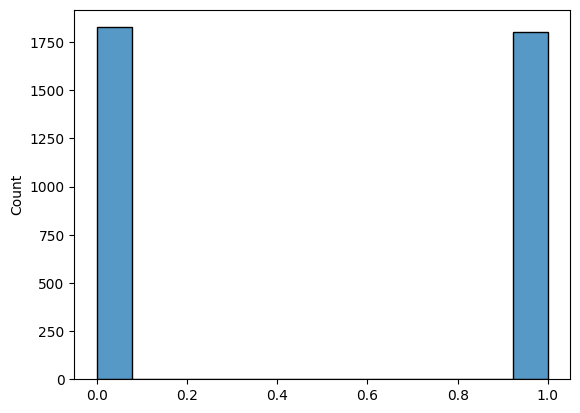

In [27]:
sns.histplot(train_labels)

In [28]:
optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-4)

In [29]:
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224,224,3))
base_model.trainable = False

inputs = layers.Input(shape=(224,224,3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = models.Model(inputs, outputs)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    x=train_images, y=train_labels, validation_data=(valid_images,valid_labels), 
    epochs=15
    #callbacks=[callbacks.EarlyStopping(monitor="val_accuracy", patience=20, restore_best_weights=True)]
)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 50s 240ms/step - accuracy: 0.4992 - loss: 0.6940 - val_accuracy: 0.4971 - val_loss: 0.6933
Epoch 2/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.5117 - loss: 0.6925 - val_accuracy: 0.5029 - val_loss: 0.6931
Epoch 3/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.5234 - loss: 0.6921 - val_accuracy: 0.5029 - val_loss: 0.6931
Epoch 4/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.5070 - loss: 0.6936 - val_accuracy: 0.5029 - val_loss: 0.6931
Epoch 5/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.5057 - loss: 0.6936 - val_accuracy: 0.5029 - val_loss: 0.6931
Epoch 6/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.5043 - loss: 0.6933 - val_accuracy: 0.5029 - val_loss: 0.6931
Epoch 7/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.5251 - loss: 0.6923 - val_accuracy: 0.5029 - val_loss: 0.6931
Epoch 8/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 5s 4

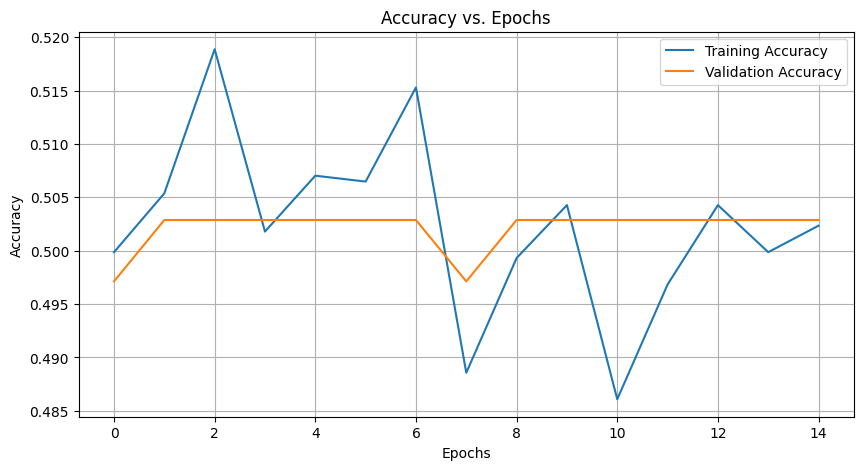

In [30]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [31]:
model.predict(test_images).flatten()

6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step


array([0.4988505 , 0.49884716, 0.49881506, 0.49885362, 0.49883857,
       0.4989066 , 0.4988587 , 0.498848  , 0.49881282, 0.4988588 ,
       0.49884692, 0.4988423 , 0.49885392, 0.49883685, 0.49884942,
       0.49884433, 0.49884266, 0.4988728 , 0.49884894, 0.49883768,
       0.49881512, 0.49884212, 0.4988423 , 0.49884954, 0.49884057,
       0.498841  , 0.49885276, 0.4988556 , 0.4988511 , 0.49884588,
       0.49883175, 0.49886438, 0.4988477 , 0.49884164, 0.49884787,
       0.49885002, 0.49886486, 0.49884942, 0.49884552, 0.49885157,
       0.49884978, 0.4988474 , 0.49884775, 0.49885327, 0.4988517 ,
       0.49884337, 0.49884835, 0.49886593, 0.49885276, 0.49882907,
       0.4988461 , 0.49884164, 0.49884224, 0.49884373, 0.4988588 ,
       0.49885356, 0.4988484 , 0.4988499 , 0.49884397, 0.49884674,
       0.49885833, 0.49885714, 0.49884337, 0.49885893, 0.4988284 ,
       0.49884692, 0.4988206 , 0.49885547, 0.4988391 , 0.49885044,
       0.49884883, 0.49884942, 0.4988436 , 0.49884823, 0.49884

6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step
Confusion Matrix:
 [[86  0]
 [83  0]]

Classification Report:
               precision    recall  f1-score   support

           0       0.51      1.00      0.67        86
           1       0.00      0.00      0.00        83

    accuracy                           0.51       169
   macro avg       0.25      0.50      0.34       169
weighted avg       0.26      0.51      0.34       169

ROC AUC: 0.4314934155225554


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


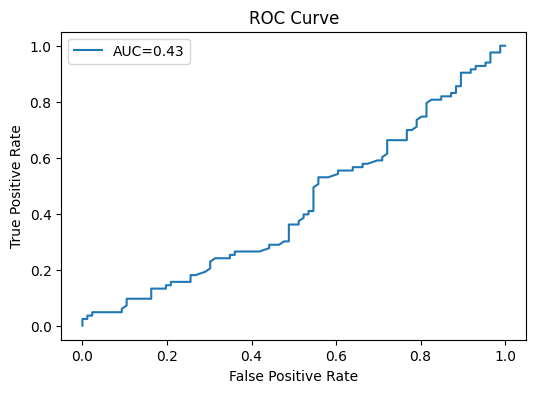

In [32]:
# Predict on test set
y_pred_probs = model.predict(test_ds).flatten()
y_pred = (y_pred_probs > 0.5).astype(int)

# Confusion matrix
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

print("Confusion Matrix:\n", confusion_matrix(test_labels, y_pred))
print("\nClassification Report:\n", classification_report(test_labels, y_pred))
print("ROC AUC:", roc_auc_score(test_labels, y_pred_probs))

# ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, y_pred_probs)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC={roc_auc_score(test_labels, y_pred_probs):.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [33]:
from tensorflow.keras.applications.resnet import preprocess_input

train_prep = preprocess_input(train_images)
valid_prep = preprocess_input(valid_images)

base_model = ResNet152V2(weights="imagenet", include_top=False, input_shape=(224,224,3))
base_model.trainable = False

inputs = layers.Input(shape=(224,224,3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = models.Model(inputs, outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_prep, train_labels, validation_data=(valid_prep,valid_labels), epochs=20,
    #callbacks=[callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)]
)


234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 76s 435ms/step - accuracy: 0.5229 - loss: 538.7437 - val_accuracy: 0.4971 - val_loss: 94.6992
Epoch 2/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 28s 245ms/step - accuracy: 0.5098 - loss: 356.9059 - val_accuracy: 0.5029 - val_loss: 33.5008
Epoch 3/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 26s 227ms/step - accuracy: 0.5257 - loss: 204.0490 - val_accuracy: 0.4971 - val_loss: 73.6789
Epoch 4/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 26s 224ms/step - accuracy: 0.5107 - loss: 134.8889 - val_accuracy: 0.5029 - val_loss: 59.0921
Epoch 5/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 26s 232ms/step - accuracy: 0.4929 - loss: 95.7327 - val_accuracy: 0.5029 - val_loss: 83.8247
Epoch 6/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 26s 230ms/step - accuracy: 0.4913 - loss: 77.4402 - val_accuracy: 0.5029 - val_loss: 24.3451
Epoch 7/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 26s 227ms/step - accuracy: 0.5213 - loss: 62.4060 - val_accuracy: 0.5029 - val_loss: 51.7621
Epoch 8/20
1

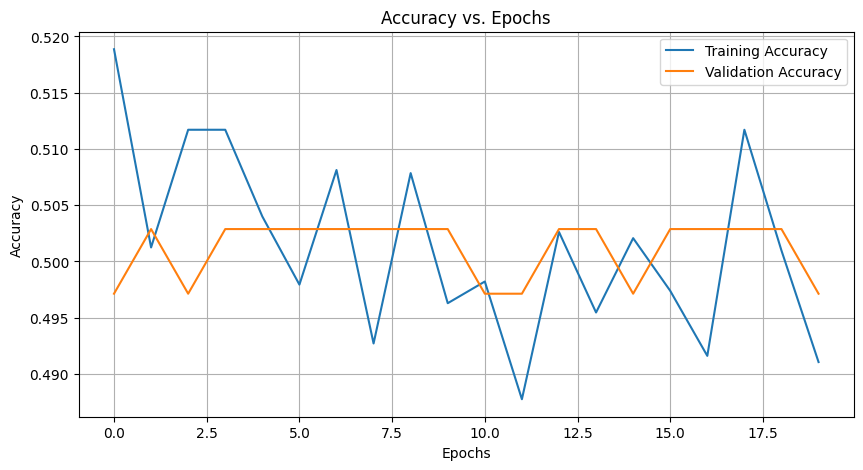

In [34]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step
Confusion Matrix:
 [[10 76]
 [ 7 76]]

Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.12      0.19        86
           1       0.50      0.92      0.65        83

    accuracy                           0.51       169
   macro avg       0.54      0.52      0.42       169
weighted avg       0.54      0.51      0.42       169

ROC AUC: 0.5046231437377418


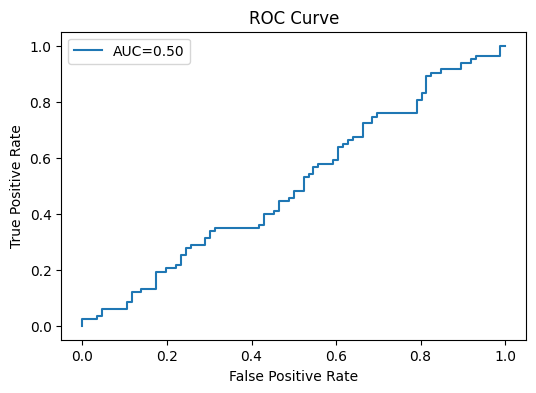

In [35]:
# Predict on test set
y_pred_probs = model.predict(test_ds).flatten()
y_pred = (y_pred_probs > 0.5).astype(int)

# Confusion matrix
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

print("Confusion Matrix:\n", confusion_matrix(test_labels, y_pred))
print("\nClassification Report:\n", classification_report(test_labels, y_pred))
print("ROC AUC:", roc_auc_score(test_labels, y_pred_probs))

# ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, y_pred_probs)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC={roc_auc_score(test_labels, y_pred_probs):.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [36]:
# sns.histplot(augmented_labels)

In [37]:
# aug_images = np.array(augmented_images)
# aug_labels = np.array(augmented_labels)

# # Shuffle
# perm = np.random.permutation(len(aug_images))
# aug_images = aug_images[perm]
# aug_labels = aug_labels[perm]

In [38]:
# train_images = aug_images / 255.0
# valid_images = valid_images / 255.0
# test_images = test_images / 255.0

In [39]:
# num_classes = len(label_encoder.classes_)
# train_labels_cat = to_categorical(aug_labels, num_classes)
# valid_labels_cat = to_categorical(valid_labels_enc, num_classes)
# test_labels_cat = to_categorical(test_labels_enc, num_classes)

In [40]:
# datagen = ImageDataGenerator(
#     rotation_range=10,
#     width_shift_range=0.05,
#     height_shift_range=0.05,
#     zoom_rangfrom tensorflow.keras import mixed_precision
# mixed_precision.set_global_policy("mixed_float16")

# # Setup EfficientNet
# base_model = EfficientNetB0(
#     weights="imagenet",
#     include_top=False,
#     input_shape=(225, 225, 3)
# )
# base_model.trainable = False

# inputs = Input(shape=(225, 225, 3))
# x = base_model(inputs, training=False)
# x = layers.GlobalAveragePooling2D()(x)
# x = layers.Dropout(0.5)(x)
# outputs = layers.Dense(NUM_CLASSES, activation="softmax", dtype="float32")(x)

# model = models.Model(inputs, outputs)
# model.compile(
#     optimizer=tf.keras.optimizers.Adam(1e-3),
#     loss="categorical_crossentropy",
#     metrics=["accuracy"]
# )

# # Dataset pipeline
# train_ds = tf.data.Dataset.from_tensor_slices((aug_images, aug_labels_cat)).batch(8).prefetch(tf.data.AUTOTUNE)
# val_ds = tf.data.Dataset.from_tensor_slices((valid_images, valid_labels_cat)).batch(8).prefetch(tf.data.AUTOTUNE)

# # Train
# model.fit(
#     train_ds,
#     validation_data=val_ds,
#     epochs=20,
#     callbacks=[callbacks.EarlyStopping(monitor="val_accuracy", patience=8, restore_best_weights=True)]
# )e=0.1,
#     horizontal_flip=True,
#     brightness_range=[0.8, 1.2],
#     fill_mode='nearest'
# )
# datagen.fit(train_images)

In [41]:
# len(label_encoder.classes_)